In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load data
df = pd.read_feather('../data/spotify_2000_2020.feather')
df['is_hit'] = (df['popularity'] > 80).astype(int)
df['treatment'] = (df['danceability'] > df['danceability'].quantile(0.75)).astype(int)


## Step 1: Prepare the Data
We’ll compare hit rates (is_hit) for:

- Treatment: treatment = 1 → high danceability

- Control: treatment = 0 → lower danceability

In [3]:
# Split into treated and control groups
treated_hits = df[df['treatment'] == 1]['is_hit'].values
control_hits = df[df['treatment'] == 0]['is_hit'].values

# Count successes and trials
success_t = treated_hits.sum()
n_t = len(treated_hits)

success_c = control_hits.sum()
n_c = len(control_hits)

print(f"Treated: {success_t}/{n_t} hits")
print(f"Control: {success_c}/{n_c} hits")


Treated: 224/10333 hits
Control: 211/31323 hits


## Step 2: Define the Bayesian Model in PyMC
We’ll model the hit rate in each group using a Beta-Binomial model, which is great for binary outcomes.

In [4]:
with pm.Model() as model:
    # Priors for hit rates (uniform beta priors)
    p_treated = pm.Beta("p_treated", alpha=1, beta=1)
    p_control = pm.Beta("p_control", alpha=1, beta=1)

    # Likelihoods for observed data
    treated_obs = pm.Binomial("treated_obs", n=n_t, p=p_treated, observed=success_t)
    control_obs = pm.Binomial("control_obs", n=n_c, p=p_control, observed=success_c)

    # Derived: difference in hit rates
    diff = pm.Deterministic("difference", p_treated - p_control)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_treated, p_control]


/home/agnes/miniconda3/envs/data-science-env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


 Generated posterior distributions for:

- p_treated → hit rate for high-danceability songs

- p_control → hit rate for low-danceability songs

- difference → the causal lift in hit rate

## Step 3: Summarize and Visualize the Posterior

In [5]:
# Summary statistics
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_treated,0.022,0.001,0.019,0.025,0.0,0.0,8089.0,5842.0,1.0
p_control,0.007,0.000,0.006,0.008,0.0,0.0,8164.0,5832.0,1.0
difference,0.015,0.001,0.012,0.018,0.0,0.0,7999.0,5929.0,1.0


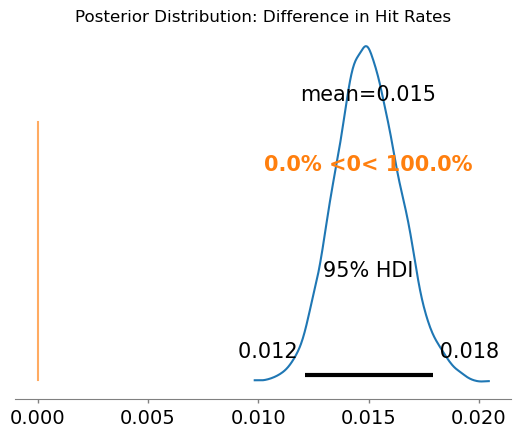

In [6]:
# Plot posterior distribution of difference in hit rate
az.plot_posterior(trace, var_names=["difference"], hdi_prob=0.95, ref_val=0)
plt.title("Posterior Distribution: Difference in Hit Rates")
plt.show()
